In [6]:
'''  PLAN

Load examples into label-specific lists
choose anchor randomly
chose positive example from same label-specific list as anchor
chose negative example from a list that differs by >=3
run all through siamese (convolutional) net
use triplet margin loss

'''

'  PLAN\n\nLoad examples into label-specific lists\nchoose anchor randomly\nchose positive example from same label-specific list as anchor\nchose negative example from a list that differs by >=3\nrun all through siamese (convolutional) net\nuse triplet margin loss\n\n'

In [7]:
# imports

import os
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# helper functions

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def make_2D(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        key_list = []
        for e in series[key]:
            key_list.append([e]) # try brackets here
        l.append(key_list)
    return l

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 3.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 2.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 1.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 0.5):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

In [36]:
# load data
with open("..\\test_examples.txt") as t:
    test_files = t.readlines()

with open("..\\training_examples.txt") as t:
    training_examples = t.readlines()

dir = '..\\time_series\\Time_normalized_stages\\4_final\\'
files = os.listdir(dir)

test_examples = []
test_labels = []

for file in test_files:
    series, num_frames = load_series(dir + file[:-1])
    test_examples.append(make_2D(series))
    test_labels.append(int(file[4]))

l_0 = []
l_1 = []
l_2 = []
l_3 = []
l_4 = []
l_5 = []
l_6 = []
l_7 = []
l_8 = []

for file in training_examples:
    series, num_frames = load_series(dir + file[:-1])
    label = int(file[4])
    if (label == 0):
        l_0.append(make_2D(series))
    elif (label == 1):
        l_1.append(make_2D(series))
    elif (label == 2):
        l_2.append(make_2D(series))
    elif (label == 3):
        l_3.append(make_2D(series))
    elif (label == 4):
        l_4.append(make_2D(series))
    elif (label == 5):
        l_5.append(make_2D(series))
    elif (label == 6):
        l_6.append(make_2D(series))
    elif (label == 7):
        l_7.append(make_2D(series))
    elif (label == 8):
        l_8.append(make_2D(series))

l_0 = torch.tensor(l_0)
l_1 = torch.tensor(l_1)
l_2 = torch.tensor(l_2)
l_3 = torch.tensor(l_3)
l_4 = torch.tensor(l_4)
l_5 = torch.tensor(l_5)
l_6 = torch.tensor(l_6)
l_7 = torch.tensor(l_7)
l_8 = torch.tensor(l_8)
test_examples = torch.tensor(test_examples)

l_0 = l_0.permute(0, 1, 3, 2)
l_1 = l_1.permute(0, 1, 3, 2)
l_2 = l_2.permute(0, 1, 3, 2)
l_3 = l_3.permute(0, 1, 3, 2)
l_4 = l_4.permute(0, 1, 3, 2)
l_5 = l_5.permute(0, 1, 3, 2)
l_6 = l_6.permute(0, 1, 3, 2)
l_7 = l_7.permute(0, 1, 3, 2)
l_8 = l_8.permute(0, 1, 3, 2)
test_examples = test_examples.permute(0, 1, 3, 2)

print(l_0.size())
print(l_1.size())
print(l_2.size())
print(l_3.size())
print(l_4.size())
print(l_5.size())
print(l_6.size())
print(l_7.size())
print(l_8.size())
print(test_examples.size())

X_train = [l_0, l_1, l_2, l_3, l_4, l_5, l_6, l_7, l_8]
print(type(X_train[0]))

torch.Size([44, 32, 1, 7])
torch.Size([94, 32, 1, 7])
torch.Size([78, 32, 1, 7])
torch.Size([54, 32, 1, 7])
torch.Size([34, 32, 1, 7])
torch.Size([25, 32, 1, 7])
torch.Size([16, 32, 1, 7])
torch.Size([18, 32, 1, 7])
torch.Size([8, 32, 1, 7])
torch.Size([93, 32, 1, 7])
<class 'torch.Tensor'>


In [222]:
# setting up CNN

conv_1 = 32
conv_2 = 64
conv_3 = 128
conv_4 = 256

fc_size1 = 256
fc_size2 = 512
fc_size3 = 256
fc_size4 = 128
fc_size5 = 64
output_size = 2
batch_size = 371
learning_rate = 0.01
tmp = 0.1
    

class SiameseNet(nn.Module):

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                m.bias.data.fill_(1.0)

    def __init__(self):
        super(SiameseNet, self).__init__()
        self.apply(self._init_weights)
        # conv layers
        self.conv1 = nn.Conv2d(conv_1, conv_2, (1,3), stride=1)
        self.conv2 = nn.Conv2d(conv_2, conv_3, (1,3), stride=1)
        self.conv3 = nn.Conv2d(conv_3, conv_4, (1,3), stride=1)
        # fc layers
        self.fc1 = nn.Linear(fc_size1, fc_size2)
        self.fc2 = nn.Linear(fc_size2, fc_size3)
        self.fc3 = nn.Linear(fc_size3, fc_size4)
        self.fc4 = nn.Linear(fc_size4, fc_size5)
        self.fc5 = nn.Linear(fc_size5, output_size)
        # sigmoid
        self.sigmoid = nn.Sigmoid()
        self.temperature = tmp
    
    def forward(self, x):
        # convolutions
        x = F.leaky_relu(self.conv1(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.1)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.1)

        #print('AFTER CONV: ' + str(x.size()))

        # fc layers
        x = torch.flatten(x, 0)

        #print('AFTER FLATTEN: ' + str(x.size()))

        x = F.leaky_relu(self.fc1(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.1)
        x = F.leaky_relu(self.fc5(x), negative_slope=0.1)

        #x = self.sigmoid(x * self.temperature)
        return x

model = SiameseNet()

triplet_loss = nn.TripletMarginLoss()
mse = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [204]:
def get_positive(anchor_label, anchor_index):
    search_space = X_train[anchor_label]
    pos_index = np.random.randint(0, high=len(search_space))
    while (pos_index == anchor_index):
        pos_index = np.random.randint(0, high=len(search_space))
    pos = search_space[pos_index]
    return pos

def get_negative(anchor_label):
    negative_label = np.random.randint(0, high=9)
    while (abs(anchor_label - negative_label) < 3):
        negative_label = np.random.randint(0, high=9)
    negative_index = np.random.randint(0, high=len(X_train[negative_label]))
    neg = X_train[negative_label][negative_index]
    return neg, abs(anchor_label - negative_label)


def get_anchor_pos_neg():
    anchor_label = np.random.randint(0, high=9)
    anchor_index = np.random.randint(0, high=len(X_train[anchor_label]))
    anchor = X_train[anchor_label][anchor_index]
    negative, label_delta = get_negative(anchor_label)
    return anchor, get_positive(anchor_label, anchor_index), negative, label_delta


EPOCH 0
EPOCH 200
EPOCH 400
EPOCH 600
EPOCH 800
EPOCH 1000
EPOCH 1200
EPOCH 1400
EPOCH 1600
EPOCH 1800


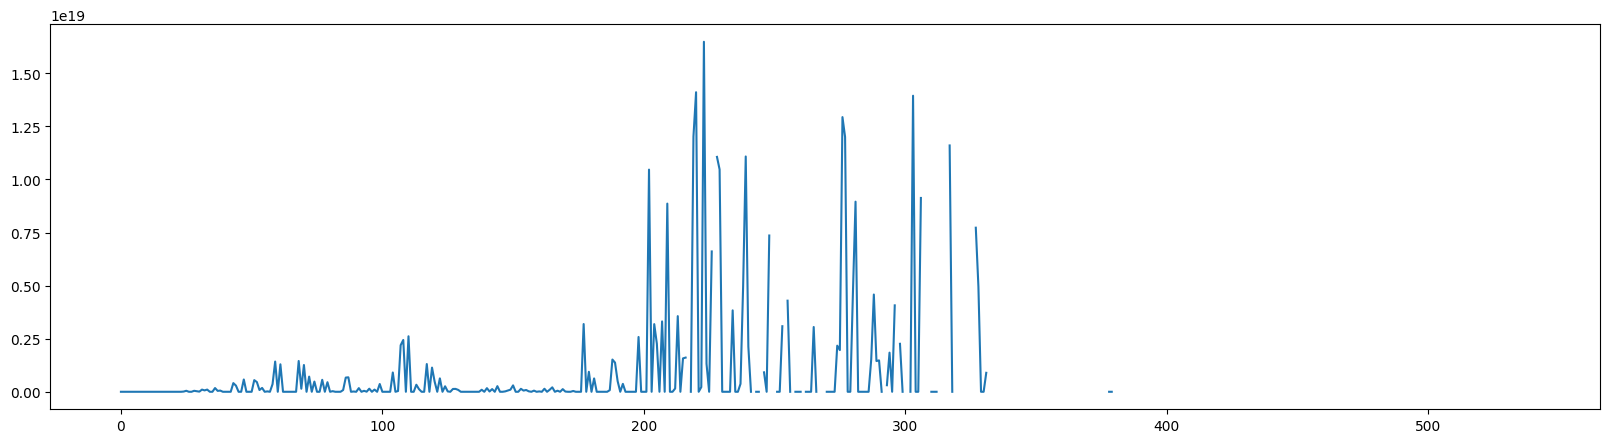

In [229]:
# training model

num_epochs = 2000

losses = []

label_to_margin_scale = 100.0

model.apply(model._init_weights)

fig, ax = plt.subplots(1, figsize=(20,5))

for epoch in range(num_epochs):
    anchor, positive, negative, label_delta = get_anchor_pos_neg()
    label_margin = label_delta * label_to_margin_scale
    #print(anchor.size())
    #print(positive.size())
    #print(negative.size())
    a_enc = model(anchor)
    p_enc = model(positive)
    n_enc = model(negative)

    triplet_loss = nn.TripletMarginLoss(margin=label_margin)

    loss = triplet_loss(a_enc, p_enc, n_enc)
    mse_loss = mse(a_enc, p_enc)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()

    if (epoch % 200 == 0):
        print('EPOCH ' + str(epoch))

ax.plot(losses)

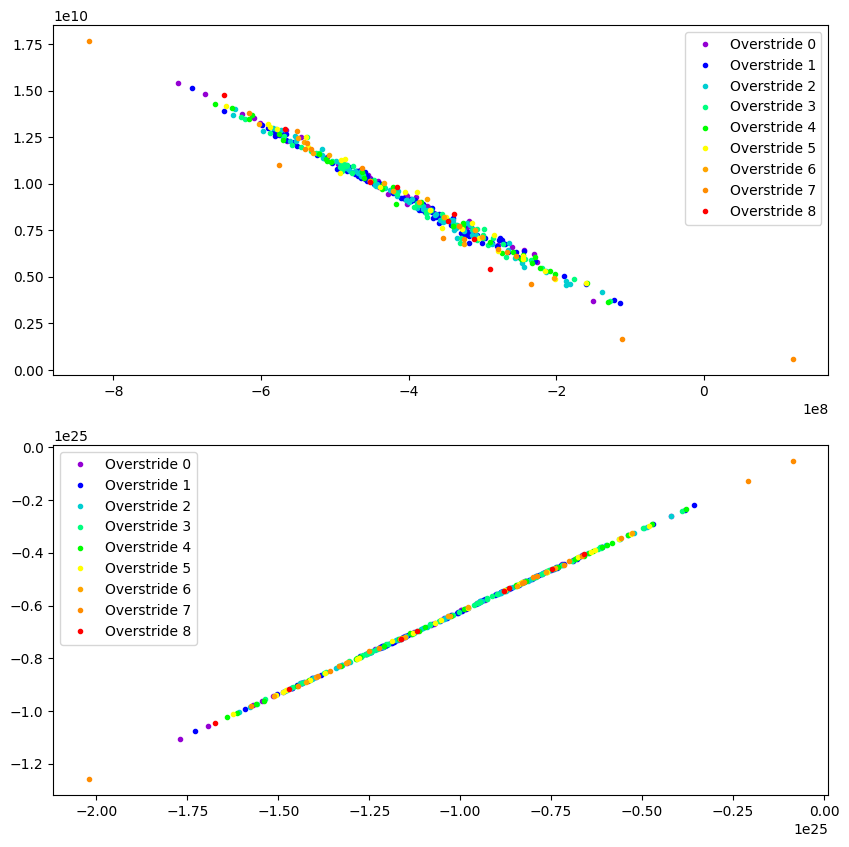

In [230]:
# examining 2d encodings


l0x = []
l0y = []
l1x = []
l1y = []
l2x = []
l2y = []
l3x = []
l3y = []
l4x = []
l4y = []
l5x = []
l5y = []
l6x = []
l6y = []
l7x = []
l7y = []
l8x = []
l8y = []

for example in X_train[0]:
    enc = model(example).tolist()
    l0x.append(enc[0])
    l0y.append(enc[1])

for example in X_train[1]:
    enc = model(example).tolist()
    l1x.append(enc[0])
    l1y.append(enc[1])

for example in X_train[2]:
    enc = model(example).tolist()
    l2x.append(enc[0])
    l2y.append(enc[1])

for example in X_train[3]:
    enc = model(example).tolist()
    l3x.append(enc[0])
    l3y.append(enc[1])

for example in X_train[4]:
    enc = model(example).tolist()
    l4x.append(enc[0])
    l4y.append(enc[1])

for example in X_train[5]:
    enc = model(example).tolist()
    l5x.append(enc[0])
    l5y.append(enc[1])

for example in X_train[6]:
    enc = model(example).tolist()
    l6x.append(enc[0])
    l6y.append(enc[1])

for example in X_train[7]:
    enc = model(example).tolist()
    l7x.append(enc[0])
    l7y.append(enc[1])

for example in X_train[8]:
    enc = model(example).tolist()
    l8x.append(enc[0])
    l8y.append(enc[1])

fig, ax = plt.subplots(2, figsize=(10, 10))

ax[1].plot(l0x, l0y, '.', c='darkviolet', label='Overstride 0')
ax[1].plot(l1x, l1y, '.', c='blue', label='Overstride 1')
ax[1].plot(l2x, l2y, '.', c='darkturquoise', label='Overstride 2')
ax[1].plot(l3x, l3y, '.', c='springgreen', label='Overstride 3')
ax[1].plot(l4x, l4y, '.', c='lime', label='Overstride 4')
ax[1].plot(l5x, l5y, '.', c='yellow', label='Overstride 5')
ax[1].plot(l6x, l6y, '.', c='orange', label='Overstride 6')
ax[1].plot(l7x, l7y, '.', c='darkorange', label='Overstride 7')
ax[1].plot(l8x, l8y, '.', c='red', label='Overstride 8')

ax[1].legend()

model.apply(model._init_weights)






l0x = []
l0y = []
l1x = []
l1y = []
l2x = []
l2y = []
l3x = []
l3y = []
l4x = []
l4y = []
l5x = []
l5y = []
l6x = []
l6y = []
l7x = []
l7y = []
l8x = []
l8y = []

for example in X_train[0]:
    enc = model(example).tolist()
    l0x.append(enc[0])
    l0y.append(enc[1])

for example in X_train[1]:
    enc = model(example).tolist()
    l1x.append(enc[0])
    l1y.append(enc[1])

for example in X_train[2]:
    enc = model(example).tolist()
    l2x.append(enc[0])
    l2y.append(enc[1])

for example in X_train[3]:
    enc = model(example).tolist()
    l3x.append(enc[0])
    l3y.append(enc[1])

for example in X_train[4]:
    enc = model(example).tolist()
    l4x.append(enc[0])
    l4y.append(enc[1])

for example in X_train[5]:
    enc = model(example).tolist()
    l5x.append(enc[0])
    l5y.append(enc[1])

for example in X_train[6]:
    enc = model(example).tolist()
    l6x.append(enc[0])
    l6y.append(enc[1])

for example in X_train[7]:
    enc = model(example).tolist()
    l7x.append(enc[0])
    l7y.append(enc[1])

for example in X_train[8]:
    enc = model(example).tolist()
    l8x.append(enc[0])
    l8y.append(enc[1])


ax[0].plot(l0x, l0y, '.', c='darkviolet', label='Overstride 0')
ax[0].plot(l1x, l1y, '.', c='blue', label='Overstride 1')
ax[0].plot(l2x, l2y, '.', c='darkturquoise', label='Overstride 2')
ax[0].plot(l3x, l3y, '.', c='springgreen', label='Overstride 3')
ax[0].plot(l4x, l4y, '.', c='lime', label='Overstride 4')
ax[0].plot(l5x, l5y, '.', c='yellow', label='Overstride 5')
ax[0].plot(l6x, l6y, '.', c='orange', label='Overstride 6')
ax[0].plot(l7x, l7y, '.', c='darkorange', label='Overstride 7')
ax[0].plot(l8x, l8y, '.', c='red', label='Overstride 8')


ax[0].legend()